In [ ]:
## PROCESS LOGIC
## First download the station data for the Gulf States (TX, LA, AL, MS, FL)
## Then clip the stations to the watershed counties 
## Use the station names to build a URL and access the narrow results from the EPA Water Quality API

In [ ]:
## URL Examples
## EPA Water Quality Site:
## https://www.waterqualitydata.us/

## Download all the stations for USA states FL, AL, TX, MS, LA as a GEOJSON:
## https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&statecode=US%3A12&statecode=US%3A48&statecode=US%3A28&statecode=US%3A22&mimeType=geojsonv&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET

## Download all the sample data for a given station (0800257-CC-05) as a CSV:
## https://www.waterqualitydata.us/data/Result/search?siteid=0800257-CC-05&mimeType=csv&zip=yes&dataProfile=narrowResult&providers=NWIS&providers=STEWARDS&providers=STORET

## CODE REFERENCE
## Arcpy Reference: https://developers.arcgis.com/python/api-reference/
## Time Sleep refernce: https://stackoverflow.com/questions/72590954/how-to-add-the-time-sleep-after-every-100-iterations

In [1]:
import arcpy
import arcgis
from arcgis.gis import GIS
#from arcgis.mapping import WebMap
from datetime import datetime
from datetime import timedelta
import urllib.request
import os
import pandas
import glob
gis = GIS("home")
arcpy.env.overwriteOutput = True
arcgis.env.verbose = True 

In [2]:
ROOT = r'C:\Temp\EPA-Water-Quality' #TODO Change to your preferred directory
TODAY = (datetime.today())
CURRENT_DATE = (TODAY.strftime('%Y%m%d'))
#WATER_QUALITY_STATIONS_URL = 'https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&countycode=US%3A01%3A003&mimeType=geojson&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET'
WATER_QUALITY_STATIONS_URL = 'https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&statecode=US%3A12&statecode=US%3A22&statecode=US%3A28&statecode=US%3A48&mimeType=geojson&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET'
WORKING_DIRECTORY = ROOT + '\\working_' + str(CURRENT_DATE) + '\\'
WATER_QUALITY_STATIONS_DIRECTORY = WORKING_DIRECTORY + '\\stations\\'
WATER_QUALITY_STATIONS_ZIP = WATER_QUALITY_STATIONS_DIRECTORY + 'water_quality_stations.zip'
WORKING_STATIONS_JSON = WORKING_DIRECTORY + 'station.geojson'
WORKING_STATIONS_SHP  = WORKING_DIRECTORY + 'station.shp'
CLIPPED_STATIONS = WORKING_DIRECTORY + 'goma_stations.shp'
COASTAL_COUNTIES = WORKING_DIRECTORY + 'coastal_watershed_counties.shp'
CSV_WORKING_DIRECTORY = WORKING_DIRECTORY + 'csv\\'

In [3]:
if not os.path.exists(ROOT):
    os.makedirs(ROOT)
if not os.path.exists(WORKING_DIRECTORY):
    os.makedirs(WORKING_DIRECTORY)
if not os.path.exists(CSV_WORKING_DIRECTORY):
    os.makedirs(CSV_WORKING_DIRECTORY)
if not os.path.exists(WATER_QUALITY_STATIONS_DIRECTORY):
    os.makedirs(WATER_QUALITY_STATIONS_DIRECTORY)

<Item title:"coastal_watershed_counties_2010" type:Feature Layer Collection owner:kvangraafeiland_oceans>
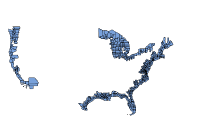

In [4]:
## Clip the stations to the specified polygon boundary 

## coastal_watershed_counties item id = ff61c0c5154d4791ae51f00c4e4a3a98
coastal_watershed_counties_item = gis.content.get('ff61c0c5154d4791ae51f00c4e4a3a98')
coastal_watershed_counties_item

In [5]:
coastal_watershed_counties_layer = coastal_watershed_counties_item.layers[0]
coastal_watershed_counties_layer

<FeatureLayer url:"https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/coastal_watershed_counties_2010/FeatureServer/0">

In [6]:
urllib.request.urlretrieve(WATER_QUALITY_STATIONS_URL, WATER_QUALITY_STATIONS_ZIP)

('C:\\Temp\\EPA-Water-Quality\\working_20230425\\\\stations\\water_quality_stations.zip',
 <http.client.HTTPMessage at 0x1e0ad212c40>)

In [7]:
import zipfile
with zipfile.ZipFile(WATER_QUALITY_STATIONS_ZIP, 'r') as zip_ref:
    zip_ref.extractall(WORKING_DIRECTORY)

In [8]:
arcpy.conversion.JSONToFeatures(WORKING_STATIONS_JSON, WORKING_STATIONS_SHP, geometry_type="POINT")

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230425\\station.shp'>

In [9]:
arcpy.analysis.PairwiseDissolve(
    in_features="https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/coastal_watershed_counties_2010/FeatureServer/0",
    out_feature_class=COASTAL_COUNTIES,
    dissolve_field=None,
    statistics_fields=None,
    multi_part="MULTI_PART",
    concatenation_separator=""
)

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230425\\coastal_watershed_counties.shp'>

In [10]:
arcpy.analysis.Clip(WORKING_STATIONS_SHP, COASTAL_COUNTIES, CLIPPED_STATIONS)

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230425\\goma_stations.shp'>

In [11]:
arcpy.management.CalculateGeometryAttributes(CLIPPED_STATIONS, [["X", "POINT_X"], ["Y", "POINT_Y"]])

<Result 'C:\\temp\\EPA-Water-Quality\\working_20230425\\goma_stations.shp'>

In [12]:
stations_df = pandas.DataFrame.spatial.from_featureclass(CLIPPED_STATIONS)
stations_df.set_index('Monitoring')
stations_df.head()

,FID,ProviderNa,Organizati,Organiza_1,Monitoring,Monitori_1,Monitori_2,ResolvedMo,HUCEightDi,siteUrl,activityCo,resultCoun,StateName,CountyName,X,Y,SHAPE
0,0,NWIS,USGS-AL,USGS Alabama Water Science Center,USEPA-304314088181501,Intake on BIG CREEK LAKE 1 18095211 AL,Facility: Diversion,Facility,03170008,https://www.waterqualitydata.us/provider/NWIS/...,0,0,Alabama,Mobile County,-88.304167,30.720556,"{""x"": -88.3041667, ""y"": 30.7205556, ""z"": 0, ""m..."
1,1,NWIS,USGS-AL,USGS Alabama Water Science Center,USEPA-304314088181502,Intake on BIG CREEK LAKE 2 18095211 AL,Facility: Diversion,Facility,03170008,https://www.waterqualitydata.us/provider/NWIS/...,0,0,Alabama,Mobile County,-88.304167,30.720556,"{""x"": -88.3041667, ""y"": 30.7205556, ""z"": 0, ""m..."
2,2,NWIS,USGS-AL,USGS Alabama Water Science Center,USEPA-313118087560401,Intake on TOMBIGBEE RIVER 21639376 AL,Facility: Diversion,Facility,03160203,https://www.waterqualitydata.us/provider/NWIS/...,0,0,Alabama,Washington County,-87.934444,31.521667,"{""x"": -87.9344444, ""y"": 31.5216667, ""z"": 0, ""m..."
3,3,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-011111111,MONTGOMERY 300 BAUD TEST STATION,Land,Land,03140202,https://www.waterqualitydata.us/provider/NWIS/...,0,0,Alabama,Autauga County,-85.999938,31.000180,"{""x"": -85.9999378, ""y"": 31.0001805, ""z"": 0, ""m..."
4,4,NWIS,USGS-AL,USGS Alabama Water Science Center,USGS-02347425,"YELLOW RIVER AT BABBIE, ALA",Stream,Stream,03140103,https://www.waterqualitydata.us/provider/NWIS/...,0,0,Alabama,Covington County,-86.348564,31.273781,"{""x"": -86.3485645, ""y"": 31.2737811, ""z"": 0, ""m..."


In [13]:
for col in stations_df.columns:
    print(col)

FID
ProviderNa
Organizati
Organiza_1
Monitoring
Monitori_1
Monitori_2
ResolvedMo
HUCEightDi
siteUrl
activityCo
resultCoun
StateName
CountyName
X
Y
SHAPE


In [14]:
# let's use the 

valueList = []  # array to hold list of values collected
valueSet = set()  # set to hold values to test against to get list
rows = arcpy.SearchCursor(WORKING_STATIONS_SHP)
field = "Monitoring"
for row in rows:
    value = row.getValue(field)
    print('Processing Station ' + value)
    old_file = os.path.join(CSV_WORKING_DIRECTORY, 'narrowresult.csv')
    new_file = os.path.join(CSV_WORKING_DIRECTORY, value +'.csv')
    sample_data_zip = CSV_WORKING_DIRECTORY + str(value) + '_' + CURRENT_DATE + '_sample_narrow.zip'
    station_narrow_url = 'https://www.waterqualitydata.us/data/Result/search?siteid=' + value + '&mimeType=csv&zip=yes&dataProfile=narrowResult&providers=NWIS&providers=STEWARDS&providers=STORET'
    urllib.request.urlretrieve(station_narrow_url, sample_data_zip)
    with zipfile.ZipFile(sample_data_zip, 'r') as zip_ref:
        zip_ref.extractall(CSV_WORKING_DIRECTORY)
    os.rename(old_file, new_file)
    os.remove(sample_data_zip)
    sample_df = pandas.read_csv(new_file)
    sample_df.rename(columns={'MonitoringLocationIdentifier':'Monitoring'}, inplace=True)
    sample_df.set_index('Monitoring')
    result = pandas.merge(sample_df, stations_df, how='left')
    result.drop(columns=['FID','SHAPE'], inplace=True)
    result.to_csv(new_file)
    for row, count in enumerate(rows):
    print(rows)
    if row == 250:
        time.sleep(60)

Processing Station ARS-MSBL-MSBL101
Processing Station ARS-MSBL-MSBL102
Processing Station ARS-MSBL-MSBL103
Processing Station ARS-MSGC-MSGC01


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-MSGC-MSGC02
Processing Station ARS-MSGC-MSGC03
Processing Station ARS-MSGC-MSGC04
Processing Station ARS-MSGC-MSGC05


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-MSGC-MSGC06
Processing Station ARS-MSGC-MSGC07


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-MSGC-MSGC08
Processing Station ARS-MSGC-MSGC09
Processing Station ARS-MSGC-MSGC10
Processing Station ARS-MSGC-MSGC11
Processing Station ARS-MSGC-MSGC12
Processing Station ARS-MSGC-MSGC13
Processing Station ARS-MSGC-MSGC14
Processing Station ARS-MSGC-MSGC_WQ_2-13
Processing Station ARS-MSGC-MSGC_WQ_2-15
Processing Station ARS-MSGC-MSGC_WQ_2-5
Processing Station ARS-MSGC-MSGC_WQ_2-9
Processing Station ARS-TXRI-TXRI_C
Processing Station ARS-TXRI-TXRI_D
Processing Station ARS-TXRI-TXRI_G
Processing Station ARS-TXRI-TXRI_SW12
Processing Station ARS-TXRI-TXRI_SW17
Processing Station ARS-TXRI-TXRI_W1


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_W10


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_W12


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_W13


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_W6
Processing Station ARS-TXRI-TXRI_Y


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_Y10


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_Y13


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_Y14


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_Y2


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_Y6


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station ARS-TXRI-TXRI_Y8


C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USEPA-304314088181501
Processing Station USEPA-304314088181502
Processing Station USEPA-313118087560401
Processing Station USEPA-323304085264801
Processing Station USEPA-323715086163001
Processing Station USEPA-323955085262001
Processing Station USEPA-324347086021901
Processing Station USEPA-331110085242201
Processing Station USEPA-332255086044101
Processing Station USEPA-332735086400401
Processing Station USEPA-332900087170001
Processing Station USEPA-333451085450601
Processing Station USEPA-333611085553301
Processing Station USEPA-334858087075901
Processing Station USEPA-335552087483101
Processing Station USEPA-335558087060001
Processing Station USEPA-335650085344001
Processing Station USEPA-335753087541001
Processing Station USEPA-340117085591401
Processing Station USEPA-340634087135601
Processing Station USEPA-341141085412601
Processing Station USEPA-341622087413301
Processing Station USEPA-342003086194801
Processing Station USEPA-342155086130601
Processing Stati

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (9,17,20,70) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02371503
Processing Station USGS-02371505
Processing Station USGS-02371600
Processing Station USGS-02371628
Processing Station USGS-02371630
Processing Station USGS-02371680
Processing Station USGS-02371698
Processing Station USGS-02371701
Processing Station USGS-02371702
Processing Station USGS-02371800
Processing Station USGS-02371825
Processing Station USGS-02371840
Processing Station USGS-02371850
Processing Station USGS-02371950
Processing Station USGS-02371975
Processing Station USGS-02372000
Processing Station USGS-02372100
Processing Station USGS-02372150
Processing Station USGS-02372250
Processing Station USGS-02372300
Processing Station USGS-02372350
Processing Station USGS-02372380
Processing Station USGS-02372400
Processing Station USGS-02372422
Processing Station USGS-02372430
Processing Station USGS-02372435
Processing Station USGS-02372475
Processing Station USGS-02372500
Processing Station USGS-02372510
Processing Station USGS-02372550
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02420045
Processing Station USGS-02420050
Processing Station USGS-02420051
Processing Station USGS-02420268
Processing Station USGS-02420270
Processing Station USGS-02420275
Processing Station USGS-02420280
Processing Station USGS-02420290
Processing Station USGS-02420320
Processing Station USGS-02420330
Processing Station USGS-02420340
Processing Station USGS-02420345
Processing Station USGS-02420355
Processing Station USGS-02420400
Processing Station USGS-02420495
Processing Station USGS-02420600
Processing Station USGS-02420760
Processing Station USGS-02420855
Processing Station USGS-02420980
Processing Station USGS-02420987
Processing Station USGS-02421000
Processing Station USGS-02421035
Processing Station USGS-02421040
Processing Station USGS-02421060
Processing Station USGS-02421090
Processing Station USGS-02421105
Processing Station USGS-02421115
Processing Station USGS-02421120
Processing Station USGS-02421135
Processing Station USGS-02421175
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (17,19,20,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02423548
Processing Station USGS-02423549
Processing Station USGS-02423550
Processing Station USGS-02423555
Processing Station USGS-02423570
Processing Station USGS-0242357007
Processing Station USGS-02423571
Processing Station USGS-02423572
Processing Station USGS-02423573
Processing Station USGS-02423576
Processing Station USGS-02423579
Processing Station USGS-02423580
Processing Station USGS-02423581
Processing Station USGS-02423584
Processing Station USGS-02423586
Processing Station USGS-02423589
Processing Station USGS-02423590
Processing Station USGS-02423591
Processing Station USGS-02423593
Processing Station USGS-02423594
Processing Station USGS-0242359498
Processing Station USGS-02423595
Processing Station USGS-0242359520
Processing Station USGS-02423596
Processing Station USGS-02423597
Processing Station USGS-02423598
Processing Station USGS-02423599
Processing Station USGS-0242359950
Processing Station USGS-02423601
Processing Station USGS-02423603
Pr

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (13,17,20,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02424010
Processing Station USGS-02424013
Processing Station USGS-02424014
Processing Station USGS-02424015
Processing Station USGS-02424025
Processing Station USGS-02424035
Processing Station USGS-02424250
Processing Station USGS-02424470
Processing Station USGS-02424500
Processing Station USGS-02424590
Processing Station USGS-02424750
Processing Station USGS-02424751
Processing Station USGS-02424910
Processing Station USGS-02424930
Processing Station USGS-02424940
Processing Station USGS-02424950
Processing Station USGS-02425000
Processing Station USGS-02425010
Processing Station USGS-02425115
Processing Station USGS-02425200
Processing Station USGS-02425250
Processing Station USGS-02425300
Processing Station USGS-02425400
Processing Station USGS-02425500
Processing Station USGS-02425530
Processing Station USGS-02425594
Processing Station USGS-02425595
Processing Station USGS-02425655
Processing Station USGS-02425700
Processing Station USGS-02425800
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (13,17,19,20,28,36,38,62,63,70) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02429506
Processing Station USGS-02429517
Processing Station USGS-02429519
Processing Station USGS-02429520
Processing Station USGS-02429525
Processing Station USGS-02429540
Processing Station USGS-02429580
Processing Station USGS-02429595
Processing Station USGS-02429605
Processing Station USGS-02429610
Processing Station USGS-02429613
Processing Station USGS-02429615
Processing Station USGS-02429620
Processing Station USGS-02429628
Processing Station USGS-02429650
Processing Station USGS-02432000
Processing Station USGS-02437784
Processing Station USGS-02437791
Processing Station USGS-02437793
Processing Station USGS-02437795
Processing Station USGS-02437800
Processing Station USGS-02437805
Processing Station USGS-02437810
Processing Station USGS-02437815
Processing Station USGS-02437825
Processing Station USGS-02437850
Processing Station USGS-02437868
Processing Station USGS-02437870
Processing Station USGS-02437880
Processing Station USGS-02437885
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (17,19,36,38) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02444500
Processing Station USGS-02444510
Processing Station USGS-02444850
Processing Station USGS-02444875
Processing Station USGS-02444995
Processing Station USGS-02445000
Processing Station USGS-02445050
Processing Station USGS-02445100
Processing Station USGS-02445115
Processing Station USGS-02445125
Processing Station USGS-02445145
Processing Station USGS-02445150
Processing Station USGS-02445152
Processing Station USGS-02445155
Processing Station USGS-02445245
Processing Station USGS-02445250
Processing Station USGS-02445253
Processing Station USGS-02445260
Processing Station USGS-02445290
Processing Station USGS-02445315
Processing Station USGS-02445320
Processing Station USGS-0244532645
Processing Station USGS-0244532650
Processing Station USGS-0244532655
Processing Station USGS-0244532660
Processing Station USGS-0244532665
Processing Station USGS-0244532670
Processing Station USGS-0244532672
Processing Station USGS-0244532675
Processing Station USGS-024

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (13,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02449005
Processing Station USGS-02449050
Processing Station USGS-02449150
Processing Station USGS-02449245
Processing Station USGS-02449250
Processing Station USGS-02449340
Processing Station USGS-02449400
Processing Station USGS-02449500
Processing Station USGS-02449680
Processing Station USGS-02449690
Processing Station USGS-02449699
Processing Station USGS-02449745
Processing Station USGS-02449750
Processing Station USGS-02449775
Processing Station USGS-02449800
Processing Station USGS-02449838
Processing Station USGS-02449840
Processing Station USGS-02449850
Processing Station USGS-02449870
Processing Station USGS-02449875
Processing Station USGS-02449880
Processing Station USGS-02449882
Processing Station USGS-02449885
Processing Station USGS-02449890
Processing Station USGS-02449900
Processing Station USGS-02449910
Processing Station USGS-02449920
Processing Station USGS-02449922
Processing Station USGS-02449924
Processing Station USGS-02449925
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (20,28,36,38,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02450285
Processing Station USGS-02450300
Processing Station USGS-02450330
Processing Station USGS-02450400
Processing Station USGS-02450440
Processing Station USGS-02450450
Processing Station USGS-02450500
Processing Station USGS-02450585
Processing Station USGS-02450600
Processing Station USGS-02450620
Processing Station USGS-02450800
Processing Station USGS-02450825
Processing Station USGS-02450850
Processing Station USGS-02451000
Processing Station USGS-02451001
Processing Station USGS-02451500
Processing Station USGS-02451535
Processing Station USGS-02451538
Processing Station USGS-02451540
Processing Station USGS-02451550
Processing Station USGS-02451580
Processing Station USGS-02451725
Processing Station USGS-02451730
Processing Station USGS-02451740
Processing Station USGS-02451750
Processing Station USGS-02451770
Processing Station USGS-02451920
Processing Station USGS-02451950
Processing Station USGS-02451952
Processing Station USGS-02452000
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02465004
Processing Station USGS-02465005
Processing Station USGS-02465080
Processing Station USGS-02465085
Processing Station USGS-02465090
Processing Station USGS-02465200
Processing Station USGS-02465205
Processing Station USGS-02465280
Processing Station USGS-02465286
Processing Station USGS-02465288
Processing Station USGS-02465290
Processing Station USGS-02465291
Processing Station USGS-02465292
Processing Station USGS-02465320
Processing Station USGS-02465325
Processing Station USGS-02465330
Processing Station USGS-02465372
Processing Station USGS-02465374
Processing Station USGS-02465375
Processing Station USGS-02465376
Processing Station USGS-02465380
Processing Station USGS-02465385
Processing Station USGS-02465390
Processing Station USGS-02465391
Processing Station USGS-02465400
Processing Station USGS-02465475
Processing Station USGS-02465490
Processing Station USGS-02465492
Processing Station USGS-02465493
Processing Station USGS-02465495
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (13,17,19,20,28,36,38,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02469765
Processing Station USGS-02469766
Processing Station USGS-02469769
Processing Station USGS-02469775
Processing Station USGS-02469790
Processing Station USGS-02469795
Processing Station USGS-02469800
Processing Station USGS-02469849
Processing Station USGS-02469850
Processing Station USGS-02470000
Processing Station USGS-02470020
Processing Station USGS-02470023
Processing Station USGS-02470035
Processing Station USGS-02470039
Processing Station USGS-02470040
Processing Station USGS-02470042
Processing Station USGS-02470043
Processing Station USGS-02470050
Processing Station USGS-02470068
Processing Station USGS-02470070
Processing Station USGS-02470072
Processing Station USGS-02470075
Processing Station USGS-02470090
Processing Station USGS-02470100
Processing Station USGS-02470108
Processing Station USGS-02470117
Processing Station USGS-02470200
Processing Station USGS-02470202
Processing Station USGS-02470205
Processing Station USGS-02470240
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-02470520
Processing Station USGS-02470530
Processing Station USGS-02470540
Processing Station USGS-02470560
Processing Station USGS-02470605
Processing Station USGS-02470607
Processing Station USGS-02470610
Processing Station USGS-02470615
Processing Station USGS-02470617
Processing Station USGS-02470629
Processing Station USGS-02470630
Processing Station USGS-02470631
Processing Station USGS-02470649
Processing Station USGS-02470700
Processing Station USGS-02470705
Processing Station USGS-02470800
Processing Station USGS-02470805
Processing Station USGS-02470810
Processing Station USGS-02470910
Processing Station USGS-02470925
Processing Station USGS-02471000
Processing Station USGS-02471001
Processing Station USGS-02471002
Processing Station USGS-02471003
Processing Station USGS-02471004
Processing Station USGS-02471005
Processing Station USGS-0247100550
Processing Station USGS-02471006
Processing Station USGS-02471007
Processing Station USGS-0247100720
Proces

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (20,22,28,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-03574799
Processing Station USGS-03574800
Processing Station USGS-03574802
Processing Station USGS-03574804
Processing Station USGS-03574806
Processing Station USGS-03574808
Processing Station USGS-03574810
Processing Station USGS-03574815
Processing Station USGS-03574816
Processing Station USGS-03574817
Processing Station USGS-03574818
Processing Station USGS-03574820
Processing Station USGS-03574823
Processing Station USGS-03574825
Processing Station USGS-03574835
Processing Station USGS-03574838
Processing Station USGS-03574840
Processing Station USGS-03574843
Processing Station USGS-03574845
Processing Station USGS-03574850
Processing Station USGS-03574855
Processing Station USGS-03574870
Processing Station USGS-03574871
Processing Station USGS-03574872
Processing Station USGS-03574970
Processing Station USGS-03574975
Processing Station USGS-03574980
Processing Station USGS-03574998
Processing Station USGS-03575000
Processing Station USGS-03575013
Processing

C:\Users\keit8223\AppData\Local\Temp\1\ipykernel_31200\2624723323.py:19: DtypeWarning: Columns (17,19,20,22,28,36,38,62) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pandas.read_csv(new_file)


Processing Station USGS-03575105
Processing Station USGS-03575110
Processing Station USGS-03575112
Processing Station USGS-03575120
Processing Station USGS-03575125
Processing Station USGS-03575140
Processing Station USGS-03575145
Processing Station USGS-03575147
Processing Station USGS-03575150
Processing Station USGS-03575151
Processing Station USGS-0357515130
Processing Station USGS-03575152
Processing Station USGS-03575153
Processing Station USGS-03575155
Processing Station USGS-03575157
Processing Station USGS-03575185
Processing Station USGS-03575193
Processing Station USGS-03575200
Processing Station USGS-03575205
Processing Station USGS-03575210
Processing Station USGS-03575220
Processing Station USGS-03575225
Processing Station USGS-03575230
Processing Station USGS-03575235
Processing Station USGS-03575245
Processing Station USGS-03575250
Processing Station USGS-03575252
Processing Station USGS-03575258
Processing Station USGS-03575260
Processing Station USGS-0357526040
Proces

KeyboardInterrupt: 

In [ ]:
# now let's merge all the CSV files into one

SAMPLE_NARROW_MERGED_CSV = CSV_WORKING_DIRECTORY + "All_GOMA_Sample_Narrow_Results.csv"
joined_files = os.path.join(CSV_WORKING_DIRECTORY, "*.csv")
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
# Finally, the files are joined
GOMA_NAROW_STATIONS_MERGED = pandas.concat(map(pandas.read_csv, joined_list), ignore_index=True)
GOMA_NAROW_STATIONS_MERGED.to_csv(SAMPLE_NARROW_MERGED_CSV, index=False)

In [ ]:
# now let's create a shpaefile from the merged CSV file

SHAPEFILE_NAME = 'sample_stations'
SAMPLE_STATIONS_SHP = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME + '.shp'
SAMPLE_STATIONS = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME

arcpy.management.XYTableToPoint(
    in_table=SAMPLE_NARROW_MERGED_CSV,
    out_feature_class=SAMPLE_STATIONS_SHP,
    x_field="X",
    y_field="Y",
    z_field=None,
    coordinate_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision'
)

In [ ]:
# now let's zip the shapefile so we can publish to arcgis online

ZIPFILE_LOCATION = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME + '.zip'

shapefiles_list = [SAMPLE_STATIONS + ".cpg",
                   SAMPLE_STATIONS + ".dbf",
                   SAMPLE_STATIONS + ".prj",
                   SAMPLE_STATIONS + ".sbn",
                   SAMPLE_STATIONS + ".sbx",
                   SAMPLE_STATIONS + ".shp",
                   SAMPLE_STATIONS + ".shp.xml",
                   SAMPLE_STATIONS + ".shx"]
with zipfile.ZipFile(ZIPFILE_LOCATION, 'w') as zipMe:        
    for file in shapefiles_list:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)